<a href="https://colab.research.google.com/github/ML-Guy/Gradient_Visualisation_and_Adversarial_Training/blob/main/Gradient_Visualisation_and_Adversarial_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic Model Training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import  confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
from tqdm.notebook import tqdm

## Parameters

In [2]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 5
augment_data = True

## Data Loader

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


In [5]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
# print(class_names)
train_ds = train_ds.cache().shuffle(1000)
if augment_data:
  train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


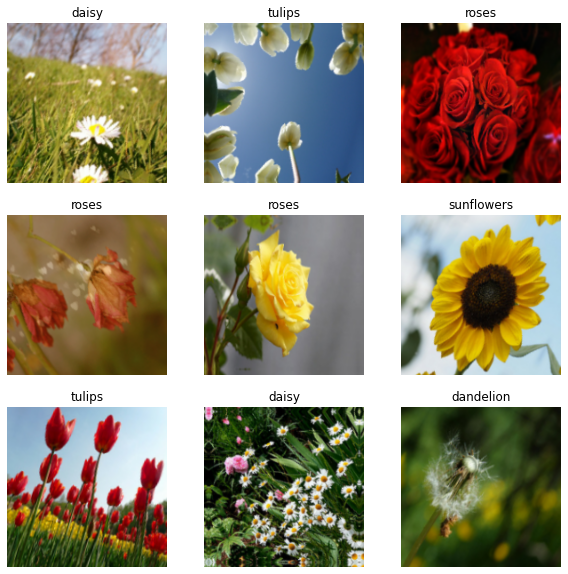

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00060726 0.9941111


## Model

In [9]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [10]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

## Training

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 110s 1s/step - loss: 1.2932 - accuracy: 0.4523 - val_loss: 1.0543 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 109s 1s/step - loss: 1.0164 - accuracy: 0.5940 - val_loss: 0.9827 - val_accuracy: 0.5804
Epoch 3/10
92/92 [==============================] - 108s 1s/step - loss: 0.9424 - accuracy: 0.6366 - val_loss: 0.8986 - val_accuracy: 0.6580
Epoch 4/10
92/92 [==============================] - 108s 1s/step - loss: 0.8464 - accuracy: 0.6754 - val_loss: 0.8256 - val_accuracy: 0.6921
Epoch 5/10
92/92 [==============================] - 108s 1s/step - loss: 0.7918 - accuracy: 0.6965 - val_loss: 0.8670 - val_accuracy: 0.6812
Epoch 6/10
92/92 [==============================] - 108s 1s/step - loss: 0.7490 - accuracy: 0.7166 - val_loss: 0.8299 - val_accuracy: 0.6689
Epoch 7/10
92/92 [==============================] - 108s 1s/step - loss: 0.7183 - accuracy: 0.7265 - val_loss: 0.7717 - val_accuracy: 0.6975
Epoch 8/10
92

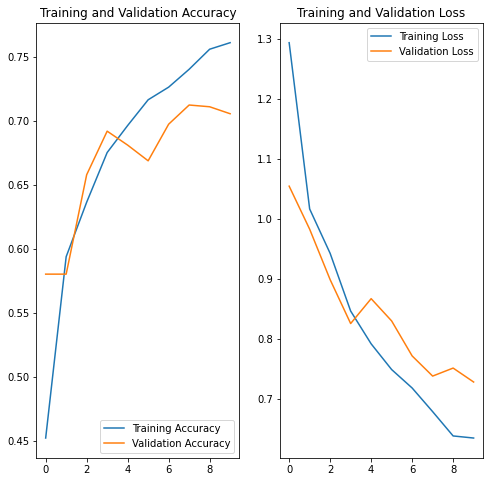

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Accuracy Visualisations

In [14]:
def get_accuracy(model, val_ds, augmentation=None):
  all_labels = []
  all_predictions = []
  for val_images, val_labels in val_ds:
    all_labels += list(val_labels.numpy())
    if augmentation:
      val_images = augmentation(val_images, val_labels)
    all_predictions += list(model(val_images).numpy().argmax(axis=1))

  return all_labels, all_predictions

def analyse_model(model, val_ds, augmentation=None, class_names=class_names):
  l,p =get_accuracy(model, val_ds, augmentation=augmentation)
  print("Accuracy Report:")
  print(classification_report(l,p,target_names=class_names))
  plt.figure(figsize = (10,7))
  cm = pd.DataFrame(confusion_matrix(l,p), index=class_names,columns=class_names)
  sn.heatmap(cm, annot=True, cmap="Blues")
  

Accuracy Report:
              precision    recall  f1-score   support

       daisy       0.78      0.64      0.70       129
   dandelion       0.79      0.70      0.75       176
       roses       0.59      0.58      0.59       120
  sunflowers       0.80      0.84      0.82       152
      tulips       0.58      0.73      0.65       157

    accuracy                           0.71       734
   macro avg       0.71      0.70      0.70       734
weighted avg       0.72      0.71      0.71       734



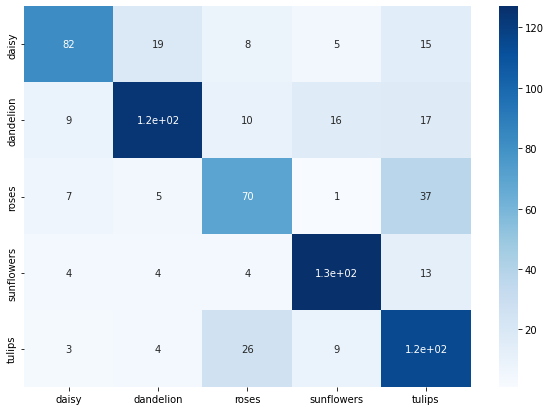

In [15]:
analyse_model(model, val_ds, augmentation=None, class_names=class_names)

# Gradient Visualisation

In [16]:
@tf.function
def compute_gradient(model_fn, loss_fn, x, y):
    with tf.GradientTape() as g:
        g.watch(x)
        # Compute loss
        loss = loss_fn(y, model_fn(x))

    # Define gradient of loss wrt input
    grad = g.gradient(loss, x)
    return grad

def vis_grad(grad,x, num_examples=1):
  g= grad.numpy()
  fig=plt.figure(frameon=False)
  fig.set_size_inches(20,20)

  for i in range(num_examples):
    real = ( ( x[i].numpy() ) ).astype(np.uint8)
    g_abs = abs(g[i])
    generated = ( g_abs/g_abs.max() * 255).astype(np.uint8)
    show = np.concatenate([real,generated],axis=1)
    fig.add_subplot(num_examples,1,i+1)
    plt.imshow(show)


In [17]:
x,y = next(iter(val_ds))
grad = compute_gradient(model, loss_fn, x, y)

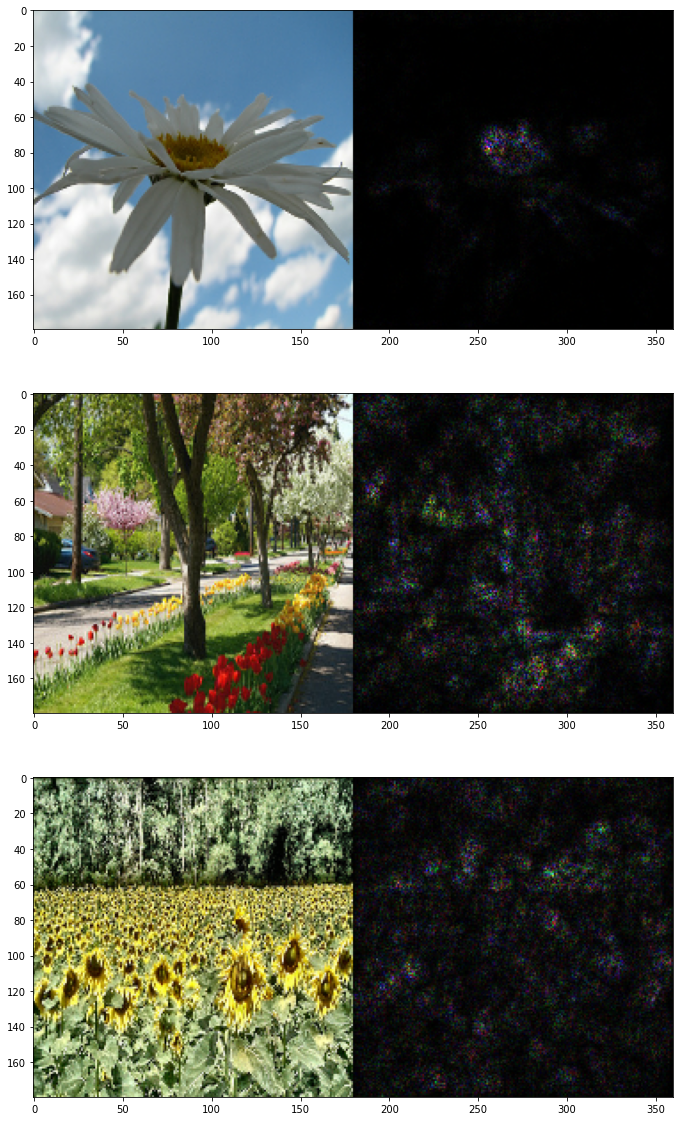

In [18]:
vis_grad(grad,x, num_examples=3)

# Random Perturbation Test

In [19]:
def random_pertubation(eps=1):
    def augmentation(val_images, val_labels):
      noise= tf.random.uniform( 
          val_images[0].shape, minval=-eps, maxval=eps, dtype=tf.dtypes.float32
          )
      return tf.clip_by_value( val_images+noise, 0, 255)

    return augmentation

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'RPT Accuracy Impact')

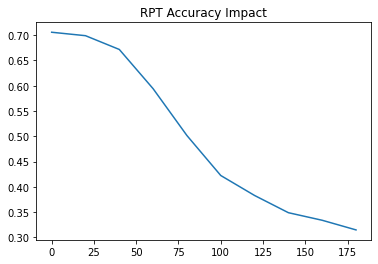

In [20]:
eps_range = list(range(0,200,20))
rpt_results = []
for e in tqdm(eps_range):
  l,p = get_accuracy(model, val_ds, augmentation=random_pertubation(eps=e))
  rpt_results.append(accuracy_score(l,p))

sn.lineplot(x=eps_range,y=rpt_results).set_title("RPT Accuracy Impact")

Accuracy Report:
              precision    recall  f1-score   support

       daisy       0.92      0.26      0.40       129
   dandelion       0.71      0.24      0.36       176
       roses       0.67      0.45      0.54       120
  sunflowers       0.63      0.79      0.70       152
      tulips       0.37      0.86      0.52       157

    accuracy                           0.52       734
   macro avg       0.66      0.52      0.50       734
weighted avg       0.65      0.52      0.50       734



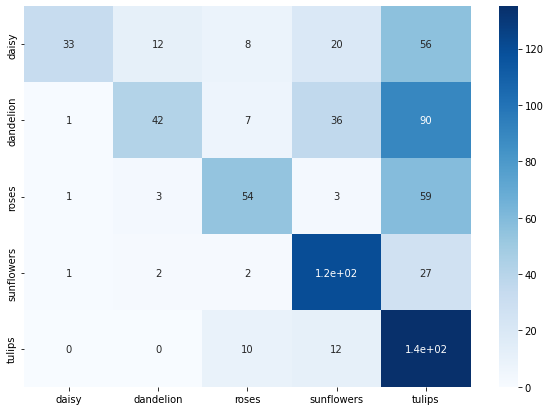

In [21]:
analyse_model(model, val_ds, augmentation=random_pertubation(eps=75))

# Adversarial Perturbation Test

In [22]:
def adversarial_pertubation(eps=1, model=model,loss_fn=loss_fn):
    def augmentation(val_images,val_labels):
      grad = compute_gradient(model, loss_fn, val_images, val_labels)
      optimal_perturbation = tf.sign(grad)
      noise= optimal_perturbation * eps
      return tf.clip_by_value( val_images+noise, 0, 255)

    return augmentation

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Adversarial Accuracy')

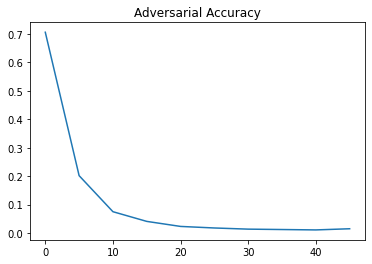

In [23]:
eps_range = list(range(0,50,5))
adv_results = []
for e in tqdm(eps_range):
  l,p = get_accuracy(model, val_ds, augmentation=adversarial_pertubation(eps=e))
  adv_results.append(accuracy_score(l,p))

sn.lineplot(x=eps_range,y=adv_results).set_title('Adversarial Accuracy')

Accuracy Report:
              precision    recall  f1-score   support

       daisy       0.08      0.05      0.06       129
   dandelion       0.12      0.07      0.09       176
       roses       0.03      0.05      0.04       120
  sunflowers       0.18      0.13      0.15       152
      tulips       0.04      0.07      0.05       157

    accuracy                           0.07       734
   macro avg       0.09      0.07      0.08       734
weighted avg       0.09      0.07      0.08       734



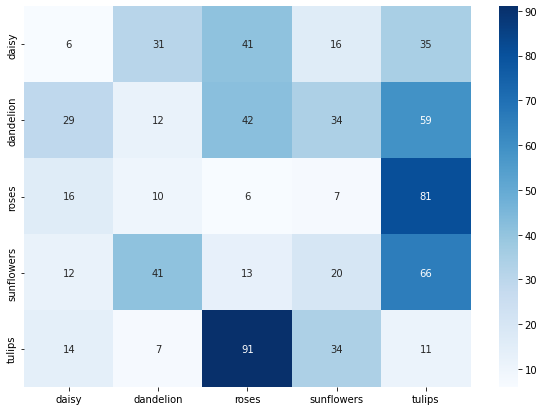

In [24]:
analyse_model(model, val_ds, augmentation=adversarial_pertubation(eps=10))

# Adversarial Regularisation term
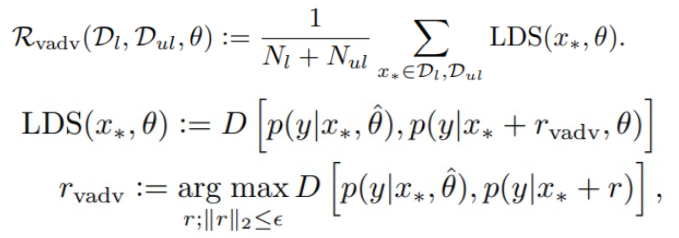



In [25]:
## Target loss - loss_fn
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Adversarial Loss - KL Divergence
kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM)

## Adversarial Perturbation Range
eps_range = list(range(0,50,5))

## Evaluation
total_loss = []
target_loss = []
adv_loss = []
for eps in tqdm(eps_range):
  total_loss_epoch = []
  target_loss_epoch = []
  adv_loss_epoch = []

  for val_images, val_labels in val_ds:
    ## Calculate Adversarial Input: X_adv
    grad = compute_gradient(model, loss_fn, val_images, val_labels)
    optimal_perturbation = tf.sign(grad)
    noise= optimal_perturbation * eps
    val_images_perturbed = tf.clip_by_value( val_images+noise, 0, 255)

    ## Model Prediction:
    # Calculate Y_pred
    y_pred = model(val_images)
    # Calculate Y_adv_pred
    y_adv_pred = model(val_images_perturbed)

    ## Loss functions:
    # target loss
    loss_t = loss_fn(val_labels,y_pred)
    # Adversarial loss 
    loss_a = kl(y_pred,y_adv_pred)
    # Total loss
    loss = loss_t + loss_a

    # collect batch losses 
    total_loss_epoch.append(loss.numpy())
    target_loss_epoch.append(loss_t.numpy())
    adv_loss_epoch.append(loss_a.numpy())


  # Collect epoch losses
  adv_loss.append(adv_loss_epoch)
  target_loss.append(target_loss_epoch)
  total_loss.append(total_loss_epoch)


  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Target loss / eps')

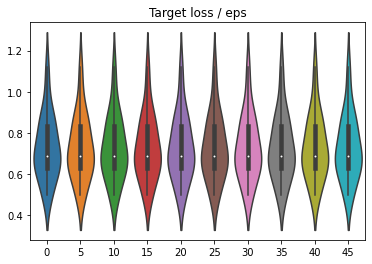

In [40]:
sn.violinplot(data = pd.DataFrame(target_loss, index=eps_range).T).set_title("Target loss / eps")

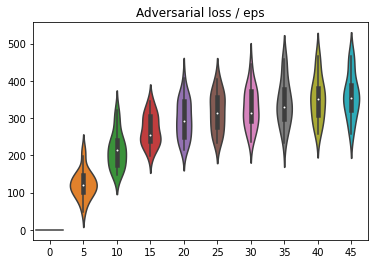

In [41]:
sn.violinplot(data = pd.DataFrame(adv_loss, index=eps_range).T).set_title("Adversarial loss / eps")

Text(0.5, 1.0, 'Total loss / eps')

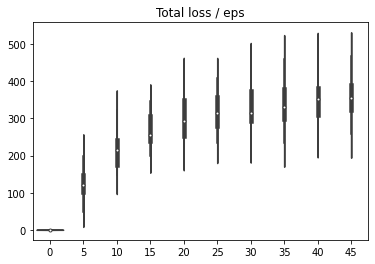

In [43]:
sn.violinplot(data = pd.DataFrame(total_loss, index=eps_range).T).set_title("Total loss / eps")